In [1]:
!pip install kagglehub

import kagglehub
import os
import shutil
import glob
import random

path = kagglehub.dataset_download("nikhilgurav21/nail-disease-detection-dataset")
print("Path to dataset files:", path)

# Get a list of all image files (modify this pattern if images are not all in 'images' subfolder)
all_images = glob.glob(os.path.join(path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(all_images))

# Fix: Only select first 1,000 images at random
selected_images = random.sample(all_images, 1000)

# Define output structure
base_output = "/content/nail_split"
splits = ["train", "test", "val"]
split_ratios = [0.8, 0.1, 0.1]
for split in splits:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

# Shuffle and split
random.shuffle(selected_images)
train_end = int(0.8 * len(selected_images))
test_end = train_end + int(0.1 * len(selected_images))

train_images = selected_images[:train_end]
test_images = selected_images[train_end:test_end]
val_images = selected_images[test_end:]

# Helper to copy files
def copy_images(files, dest_folder):
    for f in files:
        shutil.copy(f, dest_folder)

copy_images(train_images, os.path.join(base_output, "train"))
copy_images(test_images, os.path.join(base_output, "test"))
copy_images(val_images, os.path.join(base_output, "val"))

print("Split completed.")
print("Train:", len(train_images), "Test:", len(test_images), "Val:", len(val_images))


100%|██████████| 63.8M/63.8M [00:00<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhilgurav21/nail-disease-detection-dataset/versions/1
Total images found: 3835
Split completed.
Train: 800 Test: 100 Val: 100


In [2]:

import os
import shutil
import glob
from tqdm import tqdm
import random
import numpy as np
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import kagglehub
# Download the latest version
path = kagglehub.dataset_download("nikhilgurav21/nail-disease-detection-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/nail-disease-detection-dataset


In [11]:
class_names = ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']
all_images = []
# The images are in subdirectories under 'data/train' and 'data/validation'
for split in ['train', 'validation']:
    for c in class_names:
        class_imgs = glob.glob(os.path.join(path, 'data', split, c, '*.jpg'), recursive=True)
        # If .png, change pattern to '*.png'
        for imgpath in class_imgs:
            all_images.append((imgpath, c))

In [10]:
# List files in the dataset directory to understand the structure
for root, dirs, files in os.walk(path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:10]}...") # Print only first 10 files for brevity
    print("-" * 20)

Directory: /kaggle/input/nail-disease-detection-dataset
Subdirectories: ['data']
Files: []...
--------------------
Directory: /kaggle/input/nail-disease-detection-dataset/data
Subdirectories: ['validation', 'train']
Files: []...
--------------------
Directory: /kaggle/input/nail-disease-detection-dataset/data/validation
Subdirectories: ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']
Files: []...
--------------------
Directory: /kaggle/input/nail-disease-detection-dataset/data/validation/blue_finger
Subdirectories: []
Files: ['Screen-Shot-2021-10-15-at-10-44-09-AM_png.rf.fa5059ea7a03fc7853fa574ce5b05a59.jpg', 'Screen-Shot-2021-10-15-at-10-40-07-AM_png.rf.ce1377336d3cfe8a5956c7822d0f3536.jpg', 'Screen-Shot-2021-10-15-at-10-43-24-AM_png.rf.d7cfd2a2eb508c0cf55d67a6e482e83f.jpg', 'Screen-Shot-2021-10-15-at-10-44-24-AM_png.rf.0fc15e7d1ca7e1dd1009010d21c4b025.jpg', 'Screen-Shot-2021-10-15-at-10-44-09-AM_png.rf.9196975a777207fee17ee744f60

In [13]:
class_names = ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']
all_images = []
# The images are in subdirectories under 'data/train' and 'data/validation'
for split in ['train', 'validation']:
    for c in class_names:
        class_imgs = glob.glob(os.path.join(path, 'data', split, c, '*.jpg'), recursive=True)
        # If .png, change pattern to '*.png'
        for imgpath in class_imgs:
            all_images.append((imgpath, c))

print("Total images found:", len(all_images))
# Take a random subset of 1,000
random.seed(42)
all_images = random.sample(all_images, 1000)

Total images found: 3835


In [14]:
base_output = "/content/nail_split"
splits = ["train", "test", "val"]
split_ratios = [0.8, 0.1, 0.1]
samples = [int(len(all_images)*r) for r in split_ratios]
samples[-1] = len(all_images) - sum(samples[:-1]) # to fix rounding
random.shuffle(all_images)
split_data = {
    'train': all_images[:samples[0]],
    'test': all_images[samples[0]:samples[0]+samples[1]],
    'val': all_images[samples[0]+samples[1]:]
}

In [15]:
for split in splits:
    for c in class_names:
        os.makedirs(os.path.join(base_output, split, c), exist_ok=True)
    for src, label in split_data[split]:
        shutil.copy(
            src,
            os.path.join(base_output, split, label, os.path.basename(src))
        )
print("Data prepared at:", base_output)

Data prepared at: /content/nail_split


In [23]:
rotation_range = 40
brightness_range = 0.2
contrast_range = 0.2
num_augmentations = 1  # Number of augmented versions per image
augmented_dataset_folder = '/content/Augmented_Dataset'
os.makedirs(augmented_dataset_folder, exist_ok=True)
for class_name in class_names:
    src_folder = os.path.join(base_output, "train", class_name)
    dst_folder = os.path.join(augmented_dataset_folder, class_name)
    os.makedirs(dst_folder, exist_ok=True)
    for filename in tqdm(os.listdir(src_folder), desc=f"Augmenting {class_name}"):
        img_path = os.path.join(src_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        name, ext = os.path.splitext(filename)
        for i in range(num_augmentations):
            angle = random.randint(-rotation_range, rotation_range)
            M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1)
            rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            alpha = 1.0 + np.random.uniform(-brightness_range, brightness_range)
            beta = 0.5 + np.random.uniform(-contrast_range, contrast_range)
            augmented_img = cv2.convertScaleAbs(rotated, alpha=alpha, beta=beta)
            aug_name = f"{name}_aug{i}{ext}"
            cv2.imwrite(os.path.join(dst_folder, aug_name), augmented_img)
        # Save original
        cv2.imwrite(os.path.join(dst_folder, filename), img)
print("Data augmentation complete.")

Augmenting Healthy_Nail: 100%|██████████| 62/62 [00:00<00:00, 163.25it/s]

Data augmentation complete.


Visualizing images for class: pitting


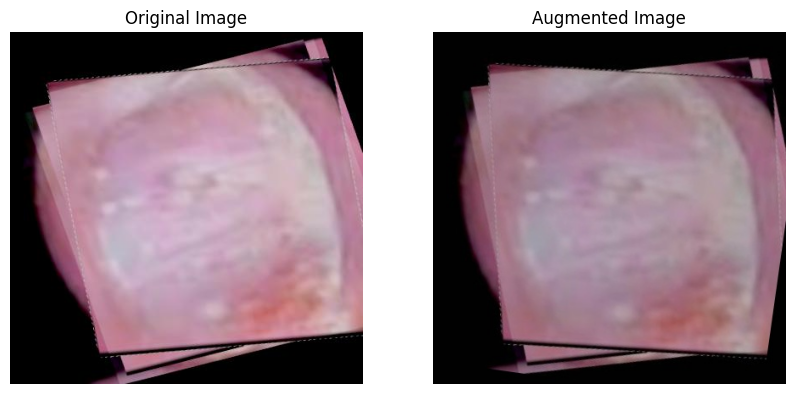

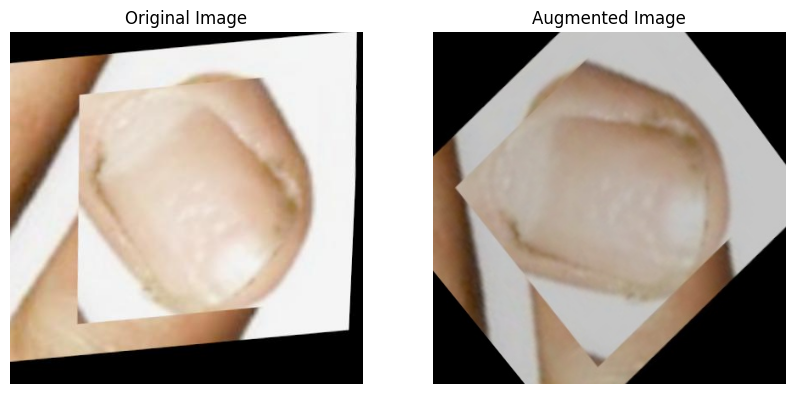

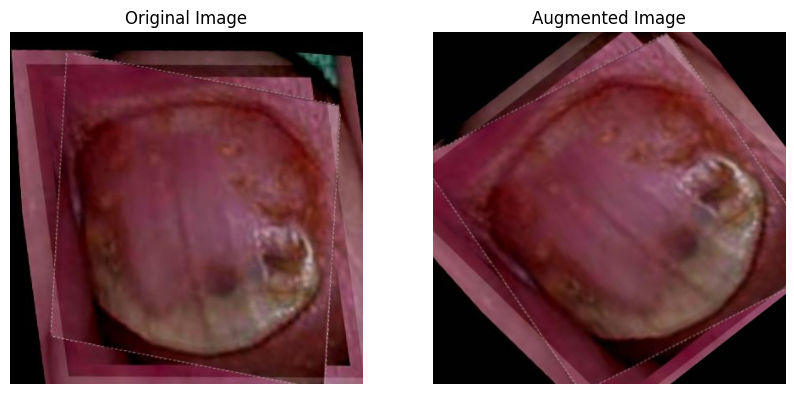

Visualizing images for class: blue_finger


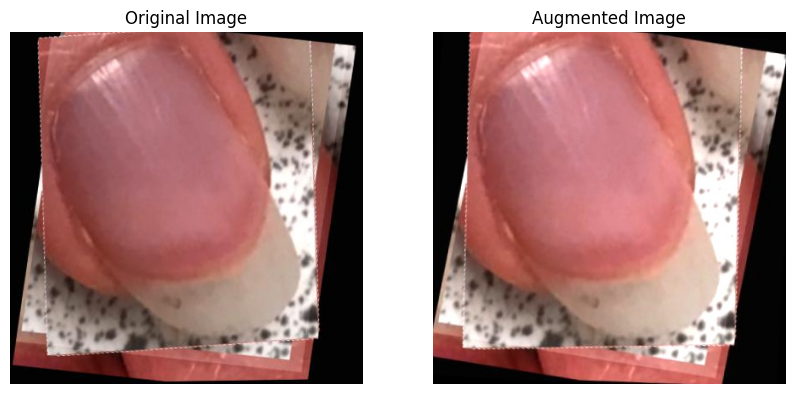

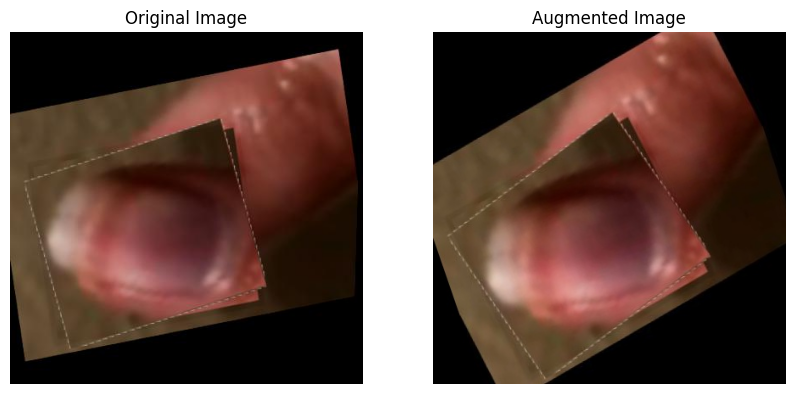

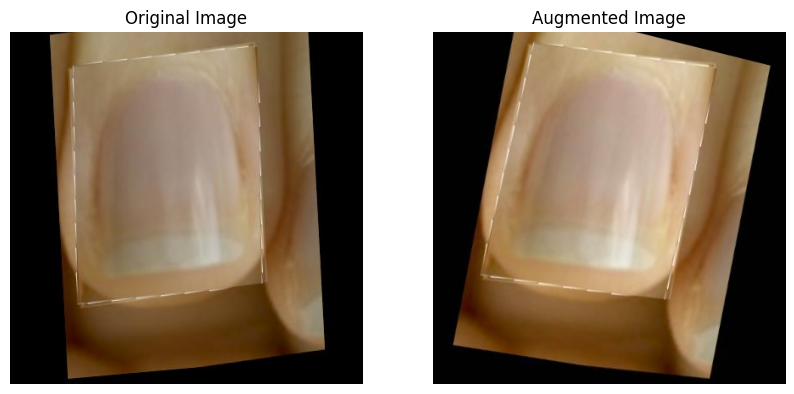

Visualizing images for class: Acral_Lentiginous_Melanoma


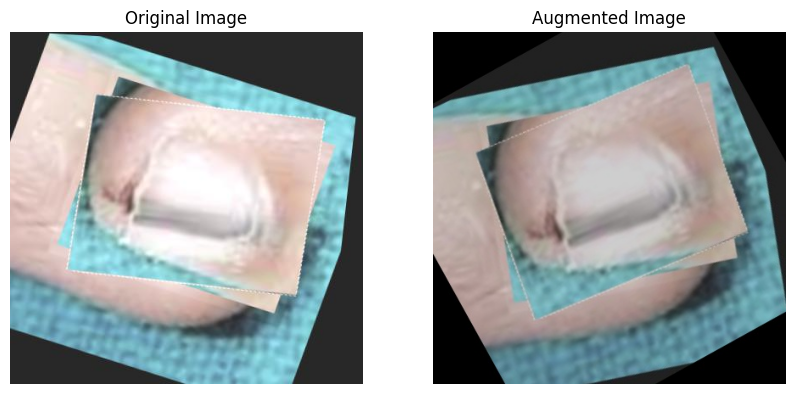

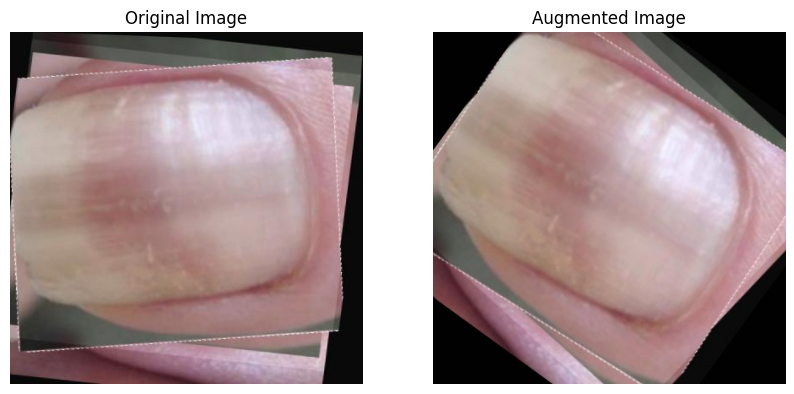

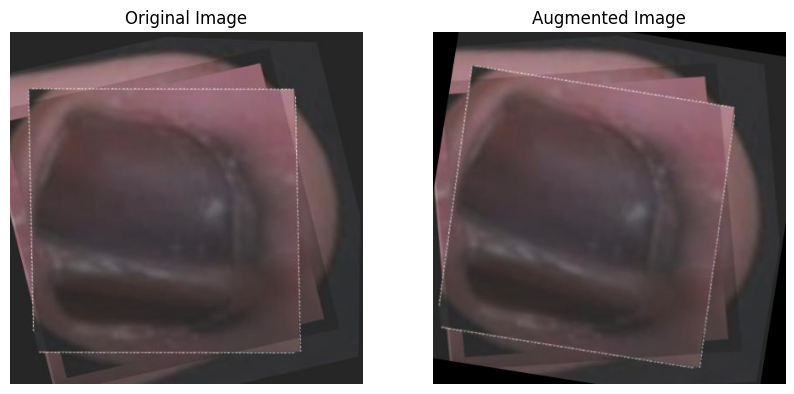

In [24]:
import matplotlib.pyplot as plt
import random
import os
import cv2

# Define the paths to the original and augmented datasets
original_dataset_folder = base_output # This is where the original split data is
augmented_dataset_folder = '/content/Augmented_Dataset'

# Select a few class names to visualize (e.g., 3 classes)
classes_to_visualize = random.sample(class_names, min(len(class_names), 3))

for class_name in classes_to_visualize:
    print(f"Visualizing images for class: {class_name}")
    original_folder = os.path.join(original_dataset_folder, "train", class_name)
    augmented_folder = os.path.join(augmented_dataset_folder, class_name)

    # Get a list of original image filenames
    original_images = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]

    # Select a few random original images to visualize (e.g., 3 images)
    images_to_show = random.sample(original_images, min(len(original_images), 3))

    for original_filename in images_to_show:
        original_img_path = os.path.join(original_folder, original_filename)
        # Assuming augmented filenames have "_aug" in them
        augmented_filenames = [f for f in os.listdir(augmented_folder) if f.startswith(os.path.splitext(original_filename)[0]) and "_aug" in f]

        # Select one augmented version if available
        augmented_filename = augmented_filenames[0] if augmented_filenames else None

        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 2, 1)
        img_original = cv2.imread(original_img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        plt.imshow(img_original)
        plt.title("Original Image")
        plt.axis("off")

        # Display augmented image if available
        if augmented_filename:
            augmented_img_path = os.path.join(augmented_folder, augmented_filename)
            img_augmented = cv2.imread(augmented_img_path)
            img_augmented = cv2.cvtColor(img_augmented, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 2, 2)
            plt.imshow(img_augmented)
            plt.title("Augmented Image")
            plt.axis("off")
        else:
            plt.subplot(1, 2, 2)
            plt.text(0.5, 0.5, "No Augmented Image Found", horizontalalignment='center', verticalalignment='center')
            plt.title("Augmented Image")
            plt.axis("off")

        plt.show()

In [25]:
image_size = 224
img_data, img_labels = [], []
for label in class_names:
    folder = os.path.join(augmented_dataset_folder, label)
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (image_size, image_size))
        img_data.append(img)
        img_labels.append(label)
img_data = np.array(img_data, dtype=np.float32) / 255.0
img_labels = np.array(img_labels)
print("Image Data Shape:", img_data.shape)
print("Label Shape:", img_labels.shape)

Image Data Shape: (1600, 224, 224, 3)
Label Shape: (1600,)


In [27]:
img_data, img_labels = shuffle(img_data, img_labels, random_state=101)
X_train_val, X_test, y_train_val, y_test = train_test_split(img_data, img_labels, test_size=0.15, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=101)
label2idx = {c: i for i, c in enumerate(class_names)}
y_train = to_categorical([label2idx[l] for l in y_train], num_classes=len(class_names))
y_val = to_categorical([label2idx[l] for l in y_val], num_classes=len(class_names))
y_test = to_categorical([label2idx[l] for l in y_test], num_classes=len(class_names))
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1119, 224, 224, 3) Val: (241, 224, 224, 3) Test: (240, 224, 224, 3)


In [28]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [29]:
input_shape = (224, 224, 3)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape, alpha=0.5)
base_model.trainable = False

# Extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

5577668/5577668 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 16)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 16)   │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 32)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 895,974 (3.42 MB)

 Trainable params: 66,438 (259.52 KB)

 Non-trainable params: 829,536 (3.16 MB)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32
)
test_loss, test_acc, test_prec, test_recall = model.evaluate(X_test, y_test)
f1_score = 2 * (test_prec * test_recall) / (test_prec + test_recall + 1e-8)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {test_prec:.4f}\nRecall: {test_recall:.4f}\nF1 score: {f1_score:.4f}")

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6705 - loss: 0.9133 - precision: 0.7554 - recall: 0.5434 - val_accuracy: 0.6888 - val_loss: 0.8613 - val_precision: 0.8278 - val_recall: 0.5187
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6540 - loss: 0.9161 - precision: 0.7672 - recall: 0.5321 - val_accuracy: 0.6888 - val_loss: 0.8572 - val_precision: 0.8235 - val_recall: 0.5228
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6619 - loss: 0.9087 - precision: 0.7678 - recall: 0.5312 - val_accuracy: 0.6888 - val_loss: 0.8539 - val_precision: 0.8258 - val_recall: 0.5311
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6812 - loss: 0.9320 - precision: 0.7793 - recall: 0.5278 - val_accuracy: 0.6971 - val_loss: 0.8494 - val_precision: 0.8153 - val_recall: 0.5311
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6673 - loss: 0.8833 - precision: 0.7677 - recall: 0.5486 - val_accuracy: 0.6971 - val_loss: 0.8439 

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 986ms/step


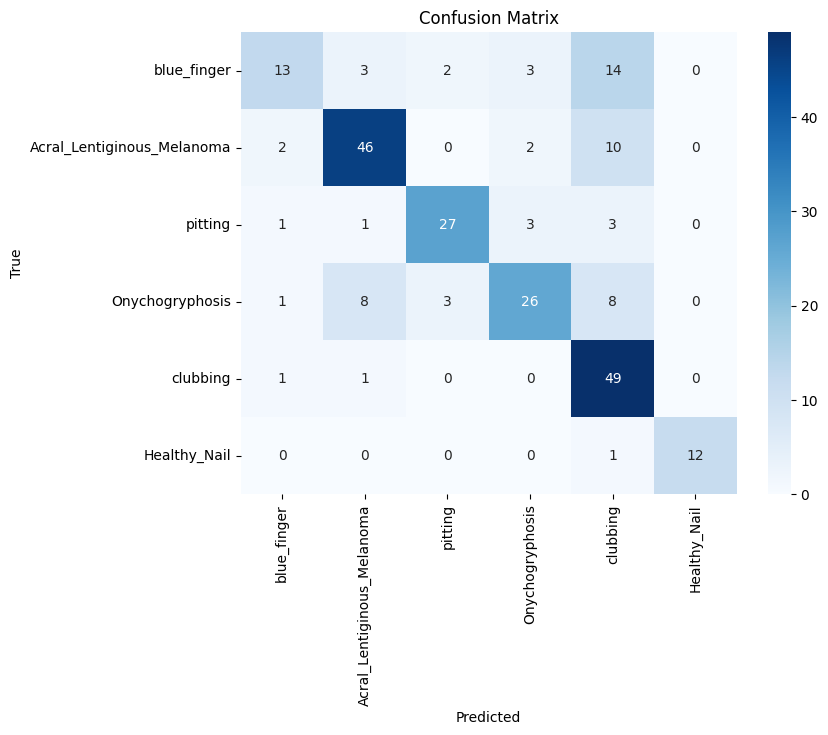

In [36]:
y_pred = model.predict(X_test)
y_true_cls = np.argmax(y_test, axis=1)
y_pred_cls = np.argmax(y_pred, axis=1)
cm = tf.math.confusion_matrix(y_true_cls, y_pred_cls, num_classes=len(class_names)).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix"); plt.show()

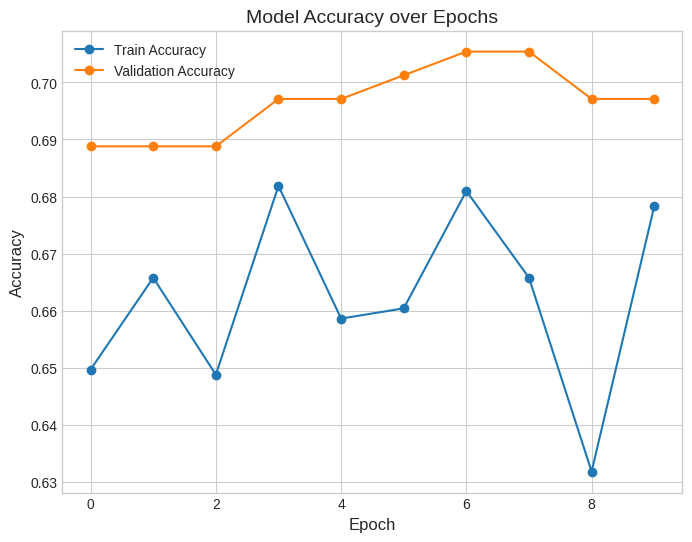

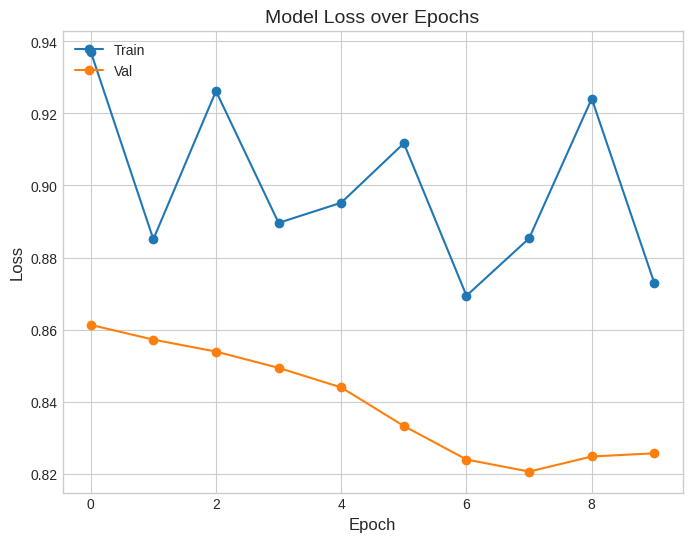

In [39]:
plt.style.use('seaborn-v0_8-whitegrid') # Using a professional looking style

# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o') # Added marker
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o') # Added marker
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o') # Added marker
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o') # Added marker
plt.title('Model Loss over Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid(True)
plt.show()

KaggleHub dataset path: /kaggle/input/nail-disease-detection-dataset
Available images: 3744


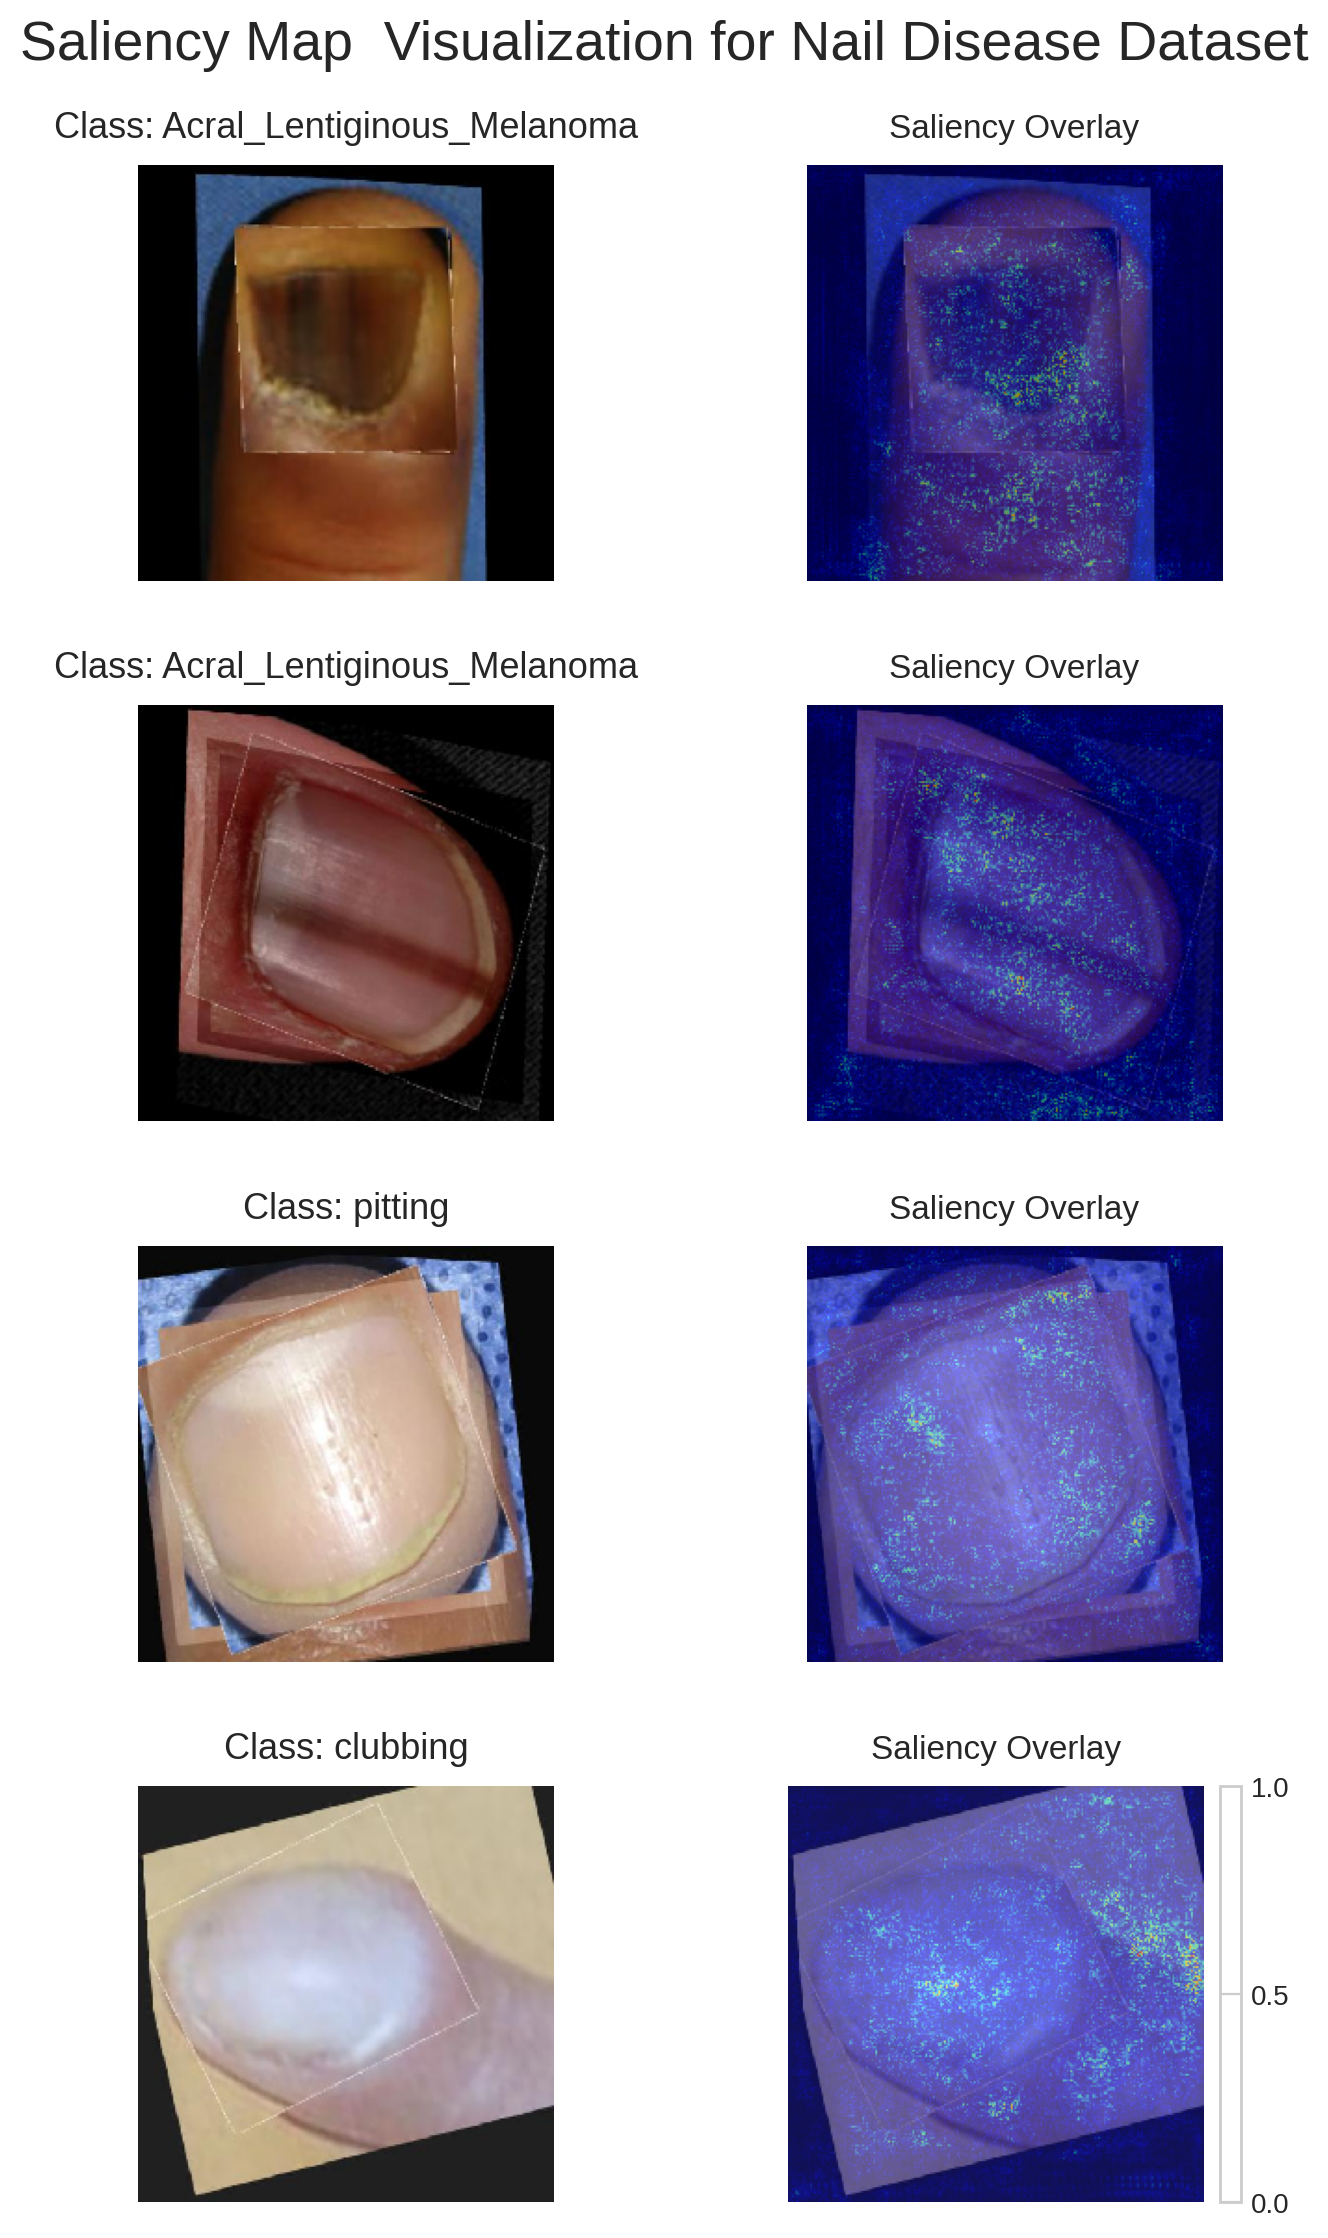

In [45]:
# --- Install and Import Required Libraries ---
!pip install kagglehub opencv-python

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.preprocessing import image as keras_image
import tensorflow as tf
import glob

# --- Download the dataset using kagglehub ---
import kagglehub

path = kagglehub.dataset_download("nikhilgurav21/nail-disease-detection-dataset")
print("KaggleHub dataset path:", path)

# --- Collect image paths for visualization ---
class_names = [
    'blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting',
    'Onychogryphosis', 'clubbing', 'Healthy_Nail'
]
all_images, class_labels = [], []
for class_name in class_names:
    class_dir = os.path.join(path, 'data', 'train', class_name)
    if os.path.exists(class_dir):
        imgs = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
        for f in imgs:
            all_images.append(os.path.join(class_dir, f))
            class_labels.append(class_name)

print("Available images:", len(all_images))

# --- Saliency Map Function ---
def compute_saliency_map(img_array, model):
    img_array = tf.cast(img_array, tf.float32)
    img_array = tf.Variable(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    gradient = tape.gradient(loss, img_array)
    saliency = tf.reduce_max(tf.abs(gradient), axis=-1)[0]
    # Normalize
    saliency -= tf.reduce_min(saliency)
    if tf.reduce_max(saliency) > 0:
        saliency /= tf.reduce_max(saliency)
    return saliency.numpy()

def load_and_preprocess(img_path, size=(224, 224)):
    pil_img = keras_image.load_img(img_path, target_size=size)
    img_arr = keras_image.img_to_array(pil_img)
    img_arr_exp = np.expand_dims(img_arr, axis=0)
    return img_arr, img_arr_exp, pil_img

# --- Use your trained model --
# If you have a model, replace this line with your model!
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

# --- Show Random Images with Saliency Maps (Well-Aligned) ---
n_show = 4
random.seed(7)
chosen = random.sample(list(zip(all_images, class_labels)), n_show)

fig, axs = plt.subplots(n_show, 2, figsize=(8, 2.8 * n_show), dpi=200, gridspec_kw={'width_ratios':[1,1]})

for i, (img_path, class_label) in enumerate(chosen):
    img_arr, img_pre, pil_img = load_and_preprocess(img_path)
    preprocessed = tf.keras.applications.mobilenet.preprocess_input(img_pre.copy())

    # Column 1: Original
    axs[i, 0].imshow(pil_img)
    axs[i, 0].set_title(f'Class: {class_label}', fontsize=13, pad=10)
    axs[i, 0].axis('off')

    # Column 2: Saliency overlay
    saliency = compute_saliency_map(preprocessed, model)
    axs[i, 1].imshow(pil_img)
    axs[i, 1].imshow(saliency, cmap='jet', alpha=0.5)
    axs[i, 1].set_title('Saliency Overlay', fontsize=12, pad=10)
    axs[i, 1].axis('off')

    if i == n_show - 1:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(axs[i, 1])
        cax = divider.append_axes("right", size="5%", pad=0.08)
        im = axs[i, 1].imshow(saliency, cmap='jet', alpha=0)
        plt.colorbar(im, cax=cax, ticks=[0, 0.5, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.93, left=0.05, right=0.97, hspace=0.3)
plt.suptitle("Saliency Map  Visualization for Nail Disease Dataset", fontsize=20, y=0.995)
plt.show()
